In [1]:
library(tidyverse)
library(lubridate)
library(repr)
library(ggthemes)
library(forecast)

NameError: name 'library' is not defined

In [50]:
monthly_core_metrics <- read_csv('./downloads/RDC_Inventory_Core_Metrics_Zip_History.csv',col_types = cols(postal_code = col_character(), zip_name 
                                                                                                          = col_character()))

Warning message:
“1 parsing failure.
   row               col expected                                   actual                                                     file
840280 month_date_yyyymm a double * year-over-year figures may be impacted './downloads/RDC_Inventory_Core_Metrics_Zip_History.csv'
”


So it turns out that their data has stripped leading 0s from zipcodes that start with a 0...which includes all of the zipcodes I am interested in. Need to fix that...

In [51]:
zip_filter <- read_csv('./zipcodes.csv', col_types = cols(zipcode = col_factor()))

In [52]:
filtered_zips_df <- monthly_core_metrics %>%
    mutate(date = ym(month_date_yyyymm)) %>%
    select(-month_date_yyyymm) %>%
    head(-2) %>%
    mutate(postal_code = ifelse(str_length(postal_code) == 4, paste0('0',postal_code), postal_code)) %>%
    mutate(postal_code = as_factor(postal_code)) %>%
    semi_join(x = ., y = zip_filter, by = c("postal_code" = "zipcode"))

In [53]:
monthly_totals <- filtered_zips_df %>%
    select(date, active_listing_count) %>%
    group_by(date) %>%
    summarize(active_listing_count = sum(active_listing_count)) %>%
    arrange(date)
head(monthly_totals,10)

`summarise()` ungrouping output (override with `.groups` argument)



date       active_listing_count
1  2016-07-01 638                 
2  2016-08-01 625                 
3  2016-09-01 593                 
4  2016-10-01 586                 
5  2016-11-01 466                 
6  2016-12-01 378                 
7  2017-01-01 344                 
8  2017-02-01 325                 
9  2017-03-01 369                 
10 2017-04-01 341

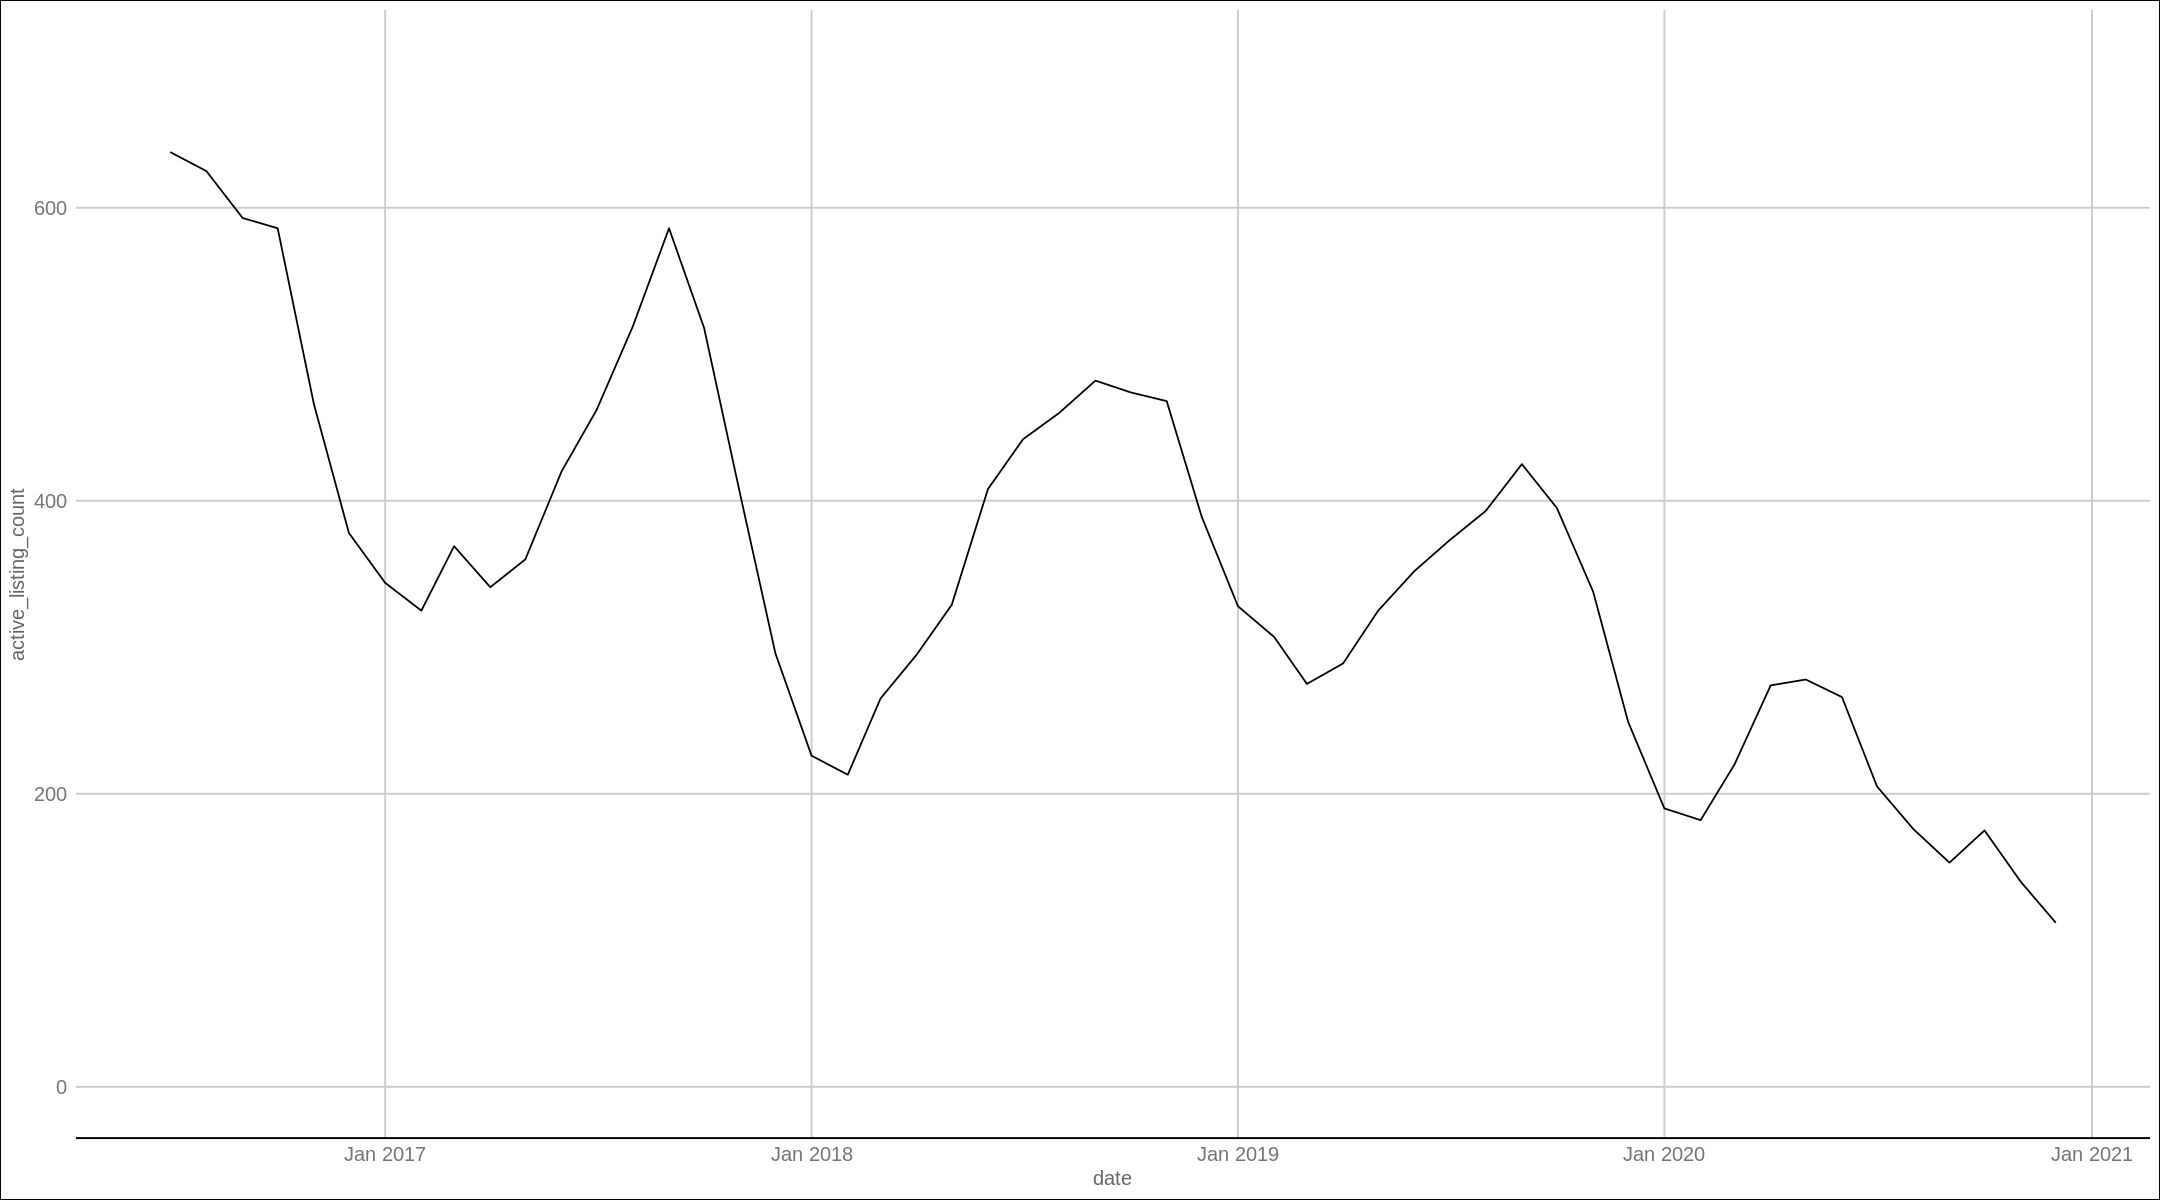

In [54]:
options(repr.plot.width=18, repr.plot.height=10)
monthly_listings_plot <- ggplot(monthly_totals, aes(x=date, y=active_listing_count)) +
    geom_line() + 
    theme_gdocs() +
    labs() + 
    ylim(0, 700) +
    scale_x_date(date_minor_breaks = "1 month", date_labels = "%b %Y")

monthly_listings_plot

Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec
2016                         638 625 593 586 466 378
2017 344 325 369 341 360 420 462 519 586 518 404 296
2018 226 213 265 295 329 408 442 460 482 474 468 389
2019 328 307 275 289 325 352 373 393 425 395 338 249
2020 190 182 220 274 278 266 205 176 153 175 140 112

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  112.0   268.0   342.5   353.7   437.8   638.0 


Forecast method: HoltWinters

Model Information:
Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = monthly_listing_ts)

Smoothing parameters:
 alpha: 0.6793688
 beta : 0
 gamma: 1

Coefficients:
           [,1]
a    121.609921
b     -6.528555
s1  -110.517124
s2  -118.435489
s3   -84.416098
s4   -54.353324
s5   -44.166790
s6   -12.983971
s7     5.762122
s8    55.083645
s9   119.323939
s10  143.133536
s11   84.991894
s12   -9.609921

Error measures:
                    ME     RMSE      MAE       MPE     MAPE      MASE      ACF1
Training set -1.944645 50.83411 37.43934 -0.651614 15.33365 0.4138032 0.5404139

Forecasts:
         Point Forecast      Lo 80     Hi 80      Lo 95    Hi 95
Jan 2021       4.564242  -61.32371  70.45219  -96.20268 105.3312
Feb 2021      -9.882677  -89.53741  69.77206 -131.70409 111.9387
Mar 2021      17.608159  -73.76215 108.97847 -122.13067 157.3470
Apr 2021      41.142377  -60.60333 142.88808 -114.46425 196.749

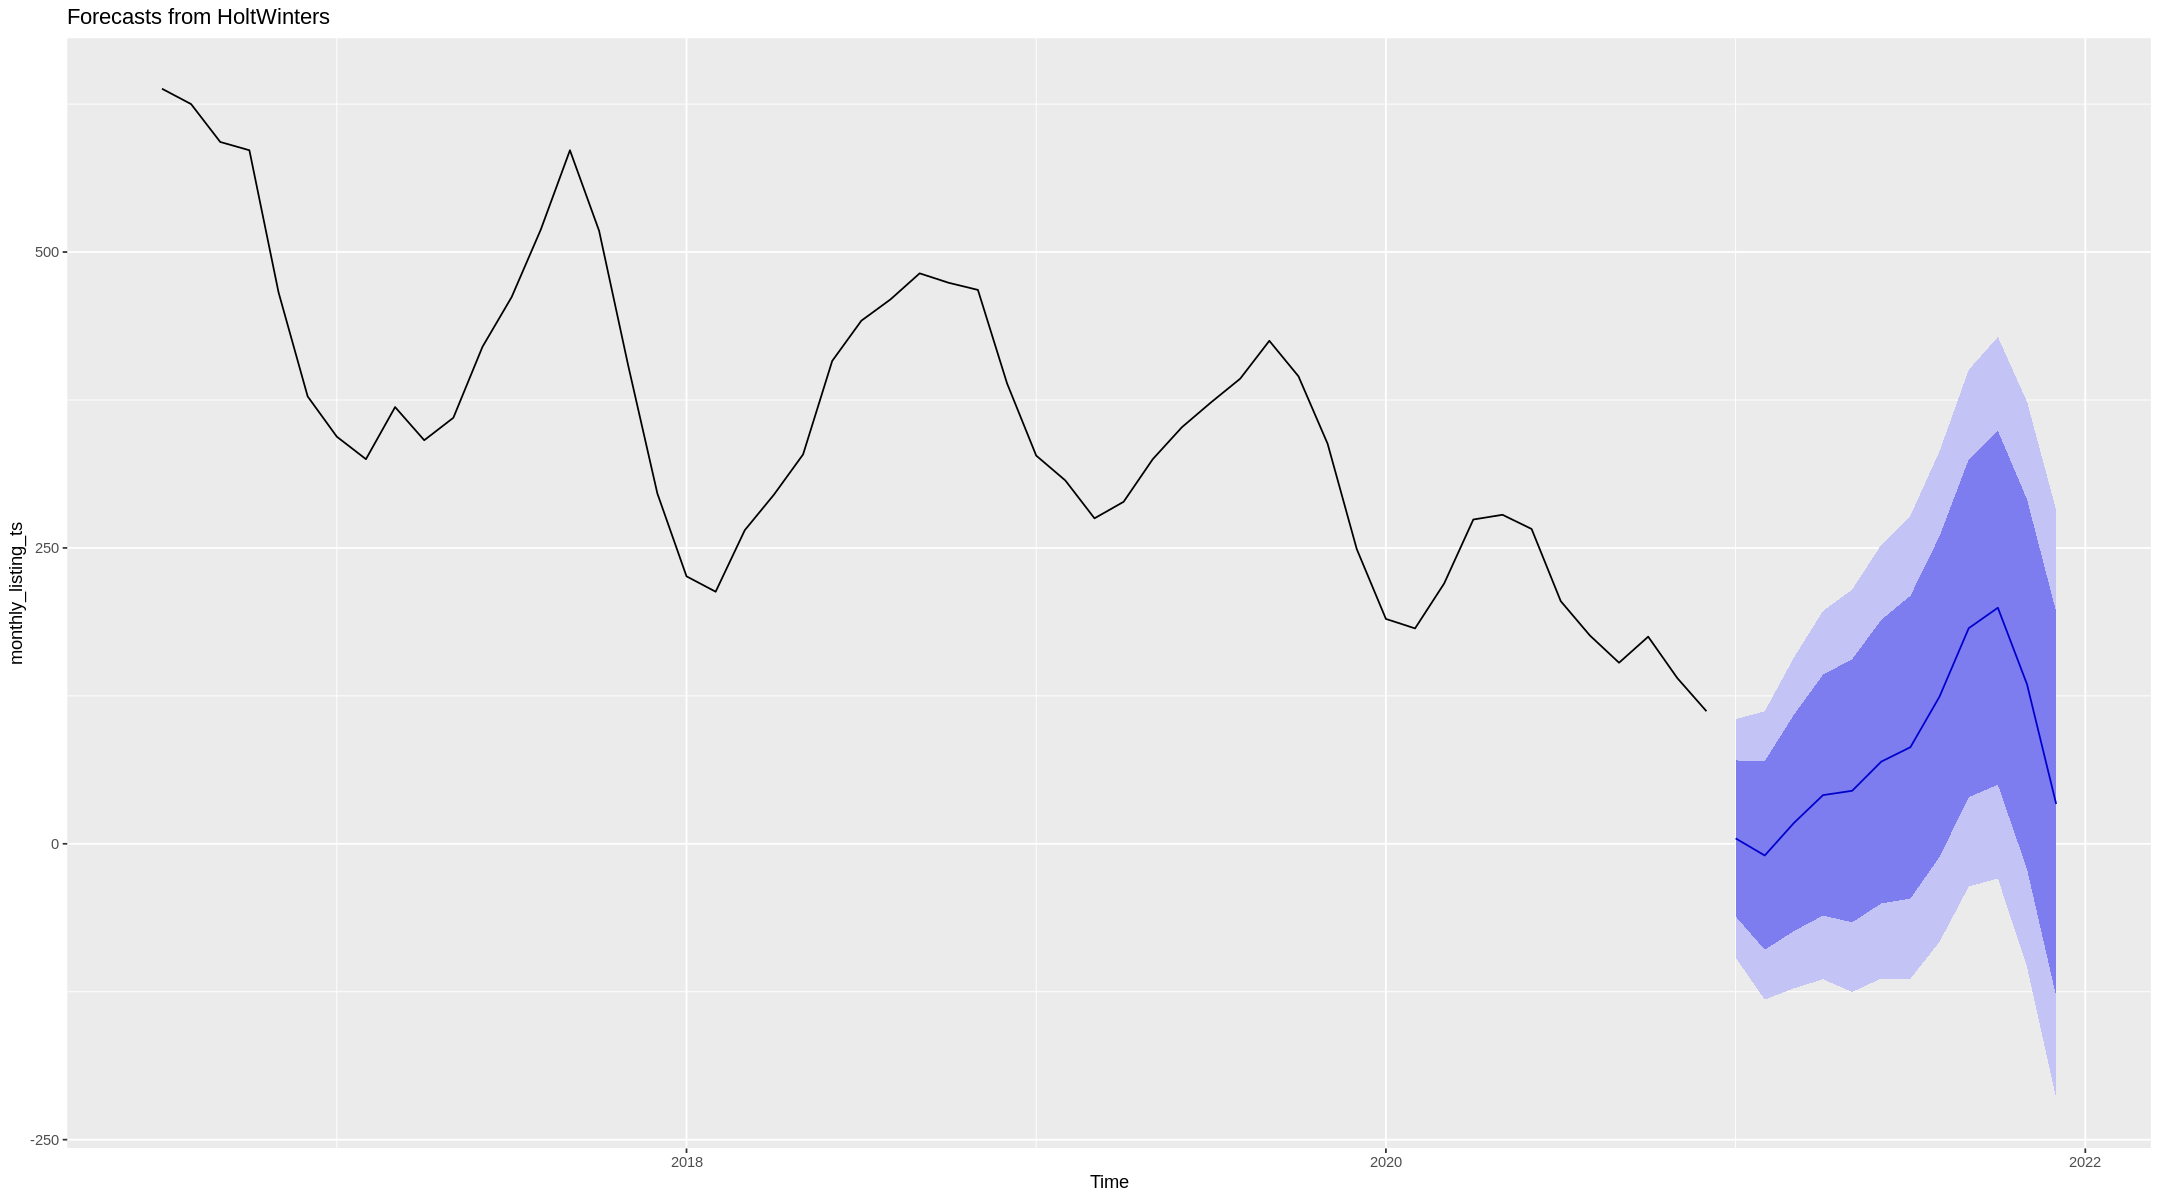

In [57]:
monthly_listing_ts <- ts(monthly_totals$active_listing_count, frequency=12, start = c(2016, 07), end = c(2020, 12))
hw <- HoltWinters(monthly_listing_ts)
hw_fc <- forecast(hw, h = 12, findfrequency = TRUE)
monthly_listing_ts
summary(monthly_listing_ts)
autoplot(hw_fc)
summary(hw_fc)